In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [265]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

### Helpers

In [3]:
# TODO try another kind of normalization, unit-normal etc.
# Normalization for DF with Credit/Debit => 0..1
def normalize(df, by="ID"):
    dfN = df.copy()
    titles = ["Debit", "Credit"]
    groups = dfN.groupby(by)
    sums = groups[titles].transform(np.sum)
    for column in titles:
        dfN[column] = dfN[column]/sums[column]
    dfN["from"] = dfN["Credit"] > 0.0
    return dfN
# Graph construction with networkX
def construct_graph(df):
        B = nx.DiGraph()
        B.add_nodes_from(df['ID'], bipartite=0)
        B.add_nodes_from(df['Name'], bipartite=1)
        B.add_weighted_edges_from(
            [(row['Name'], row['ID'], row["Credit"]) if row["from"]==True 
             else (row['ID'], row['Name'], row["Debit"]) 
             for idx, row in df.iterrows()], 
            weight='weight')
        return B
#     Graph plotting with bipartite layout
def plot_network(B, edges_label=True, title=None):
    colors = {0: "Blue", 1: "Red"}
    left = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
    pos = nx.bipartite_layout(B, left)
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw(B, pos, node_color= node_col, with_labels=False, node_size=250)
    nx.draw_networkx_edges(B, pos, arrowsize=30)
    if edges_label:
        nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
#     TODO add relative align for labels
    label_pos = pos.copy()
    for p in label_pos:  # raise text positions
        label_pos[p][1] += 0.05
    nx.draw_networkx_labels(B, pos, font_size=16)
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()

### Step function: from BP to BP

In [440]:
from scipy.special import softmax
mask = {"IN": "OUT", "OUT": "IN"}
indexes = ["IN", "OUT"]
def step(G, vertex, direction="IN", mode=2, allow_back=False, pressure=20, debug=False):
    ws = list()
    tmp_vertex = None
    tmp_weight = None
    #         Making one step from BP node to Financial account node with transition probability ~ weights of edges.
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        print("Wrong direction argument! IN or OUT are allowed!")
    if len(ins) > 0:
        ws = [edge[-1]["weight"] for edge in ins]
        p_ws = ws / np.sum(ws)
        ins = [edge[indexes.index(direction)] for edge in ins]
        tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
        tmp_vertex = ins[tmp_idx]
        tmp_weight = ws[tmp_idx]
        if debug:
            print(tmp_vertex)
    else:
        return -1
    #             Making the 2nd step from FA to BP node (actual sampling)
    if mask[direction]=="IN":
        outs = G.in_edges(tmp_vertex, data=True)
    elif mask[direction]=="OUT":
        outs = G.out_edges(tmp_vertex, data=True)
    if len(outs) > 0:
        ws = [edge[-1]["weight"] for edge in outs]
        outs = [edge[indexes.index(mask[direction])] for edge in outs]
        if not allow_back:
            rm_idx = outs.index(vertex)
            ws.pop(rm_idx)
            outs.pop(rm_idx)
        if len(outs)==0:
            return -3
        ws = np.array(ws)
        if mode == 2:
            ws = softmax((1.0 - abs(ws - tmp_weight))*pressure)
        elif mode==1:
            ws = ws/np.sum(ws)
        if debug:
            print(list(zip(outs, ws)))
        return np.random.choice(outs, p=ws)
    else:
        return -2

### Sampling: RandomWalk

In [438]:
def randomWalk(G, vertex=None, lenght=3, direction="IN", repeat=True, pressure=20, mode=2, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = step(G, cur_v, direction, mode=mode, debug=debug, pressure=pressure)
            attempts-=1
        except nx.NetworkXError:
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [253]:
def make_pairs(sampled_seq, window=3, debug=False):
    if debug:
        print(sampled_seq)
    output = list()
    for cur_idx in range(len(sampled_seq)):
        for drift in range(max(0, cur_idx-window), min(cur_idx+window, len(sampled_seq))):
            if drift != cur_idx:
                output.append((sampled_seq[cur_idx], sampled_seq[drift]))
    return output

## Experiment 1. Hierarchical

In [452]:
# Construct test case with Sale BPs with different tax rates
def generate_sales_df(N=2, taxes=[0.06, 0.15, 0.25]):
    if taxes is not None:
        tax_rates = taxes
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for tax in tax_rates:
        for _ in range(N):
            #generate amounts
            rev = random.randint(10,1000)
            t = rev*tax
            tr = rev+t
            data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
    return data

In [453]:
generated_data = normalize(generate_sales_df())
exp1 = construct_graph(generated_data)

In [454]:
generated_data.head(6)

,ID,Name,Journal,Date,Debit,Credit,from
0,0,Revenue,Sales ledger,01/01/2017,0.0,0.943396,True
1,0,Tax,Sales ledger,01/01/2017,0.0,0.056604,True
2,0,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
3,1,Revenue,Sales ledger,01/01/2017,0.0,0.943396,True
4,1,Tax,Sales ledger,01/01/2017,0.0,0.056604,True
5,1,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False


/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


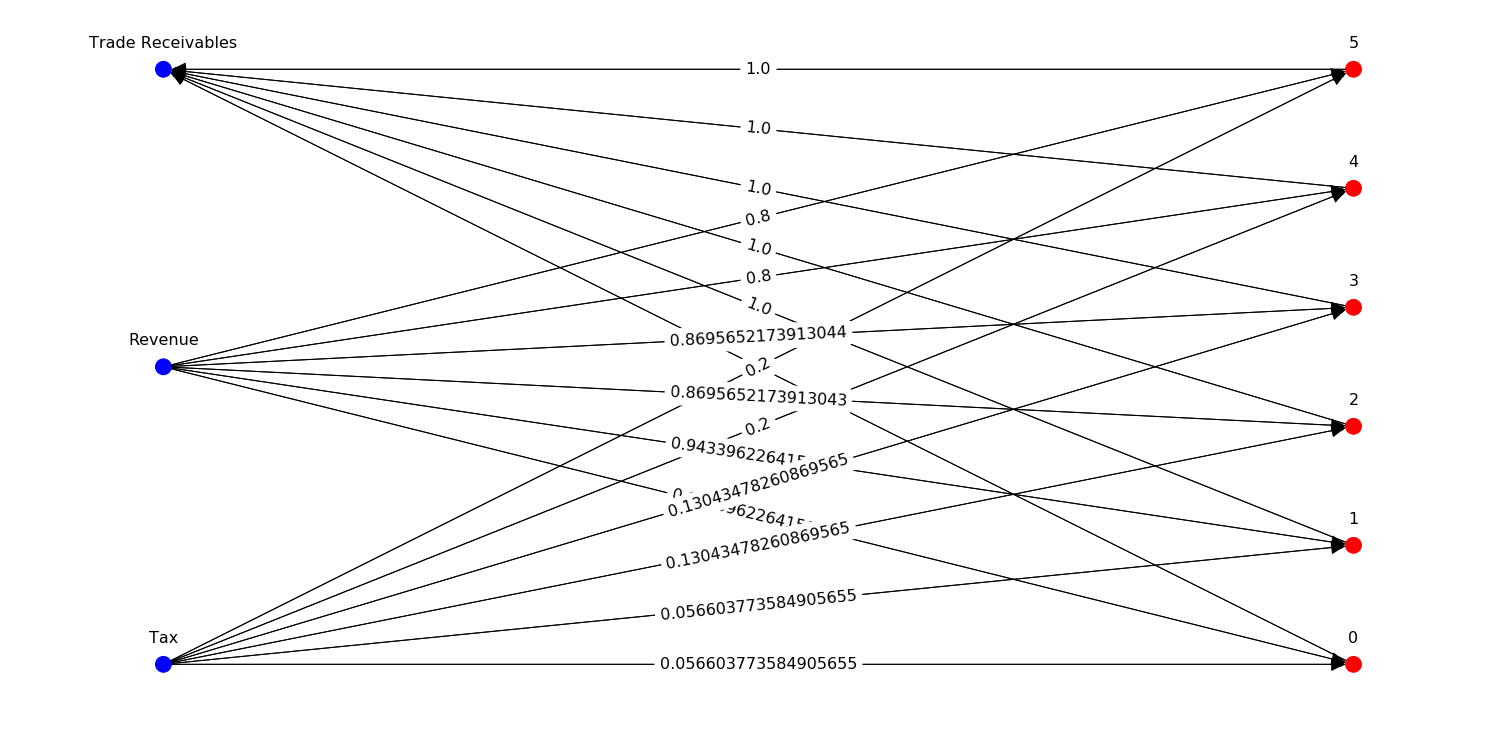

In [455]:
plot_network(exp1, title="Exp1")

In [251]:
randomWalk(exp1, 0, 10, direction="IN", repeat=False)

[0, 1, 0, 1, 2, 5, 4, 5, 3, 2, 3]

In [178]:
# -------
from collections import Counter
cnt = Counter([step(exp1, 5, mode=2, direction="OUT") for _ in range(10)])
print(cnt)

Counter({1: 4, 6: 2, 3: 2, 4: 1, 2: 1})


In [322]:
import seaborn as sns
from collections import Counter
def plot_heatmap(pairs, title="HeatMap", size=6, norm="col"):
    cnt = dict(Counter(pairs))
    heatmap_data = np.zeros((size,size))
    for key, item in cnt.items():
        heatmap_data[key] = item
    if norm=="row":
        heatmap_data = preprocessing.normalize(heatmap_data, axis=1, norm="l1")
        sns.heatmap(heatmap_data, annot=True, cmap="Blues")
    elif norm=="col":
        heatmap_data = preprocessing.normalize(heatmap_data, axis=0, norm="l1")
        mask = np.zeros_like(heatmap_data)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(heatmap_data, mask=mask, annot=True, cmap="Blues")
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()

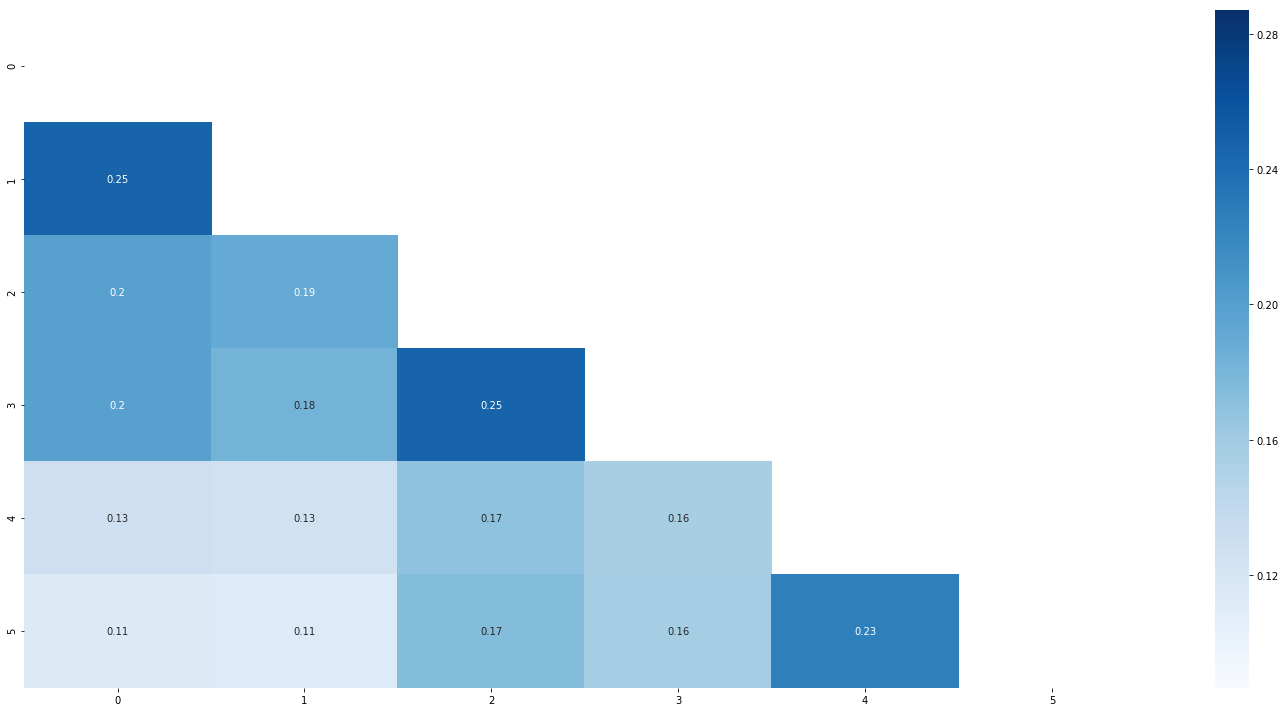

In [456]:
pairs = [make_pairs(randomWalk(exp1, node, 10, direction="IN", repeat=False, pressure=11, mode=2)) for _ in range(10) for node in range(6)]
pairs = [item for sublist in pairs for item in sublist]
plot_heatmap(pairs, norm="col")

### Experiment 2. Noisy BP

In [333]:
# Construct test case with Sale BPs with noise financial accounts (with very small monetary flow)
def generate_noisy_df(N=2, noise_ratio=0.1):
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for it in range(N):
            rev = random.randint(10,1000)
            if it//(N-3)==0:
#             if random.random()>noise_ratio:
                #generate amounts
                t = rev*0.1
                tr = rev+t
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            else:
                #generate amounts
                t = rev*0.08
                noise = rev*0.02
                right_noise1 = random.randint(5,int(rev)/20)
                right_noise2 = random.randint(5,int(rev)/20)
                tr = rev+t+noise-right_noise1-right_noise2
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                            pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                            pd.Series([cur_id, "W", "Sales ledger", "01/01/2017", 0.0, noise], index=data.columns), 
                            pd.Series([cur_id, "Z", "Sales ledger", "01/01/2017", right_noise1, 0.0], index=data.columns),
                            pd.Series([cur_id, "X", "Sales ledger", "01/01/2017", right_noise2, 0.0], index=data.columns),
                            pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                            , ignore_index=True)
            cur_id+=1
    return data

In [334]:
generated_data = normalize(generate_noisy_df(10))
exp2 = construct_graph(generated_data)
generated_data.tail(10)

,ID,Name,Journal,Date,Debit,Credit,from
29,8,W,Sales ledger,01/01/2017,0.000000,0.018182,True
30,8,Z,Sales ledger,01/01/2017,0.022173,0.000000,False
31,8,X,Sales ledger,01/01/2017,0.011826,0.000000,False
32,8,Trade Receivables,Sales ledger,01/01/2017,0.966001,0.000000,False
33,9,Revenue,Sales ledger,01/01/2017,0.000000,0.909091,True
34,9,Tax,Sales ledger,01/01/2017,0.000000,0.072727,True
35,9,W,Sales ledger,01/01/2017,0.000000,0.018182,True
36,9,Z,Sales ledger,01/01/2017,0.018680,0.000000,False
37,9,X,Sales ledger,01/01/2017,0.031133,0.000000,False
38,9,Trade Receivables,Sales ledger,01/01/2017,0.950187,0.000000,False


/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


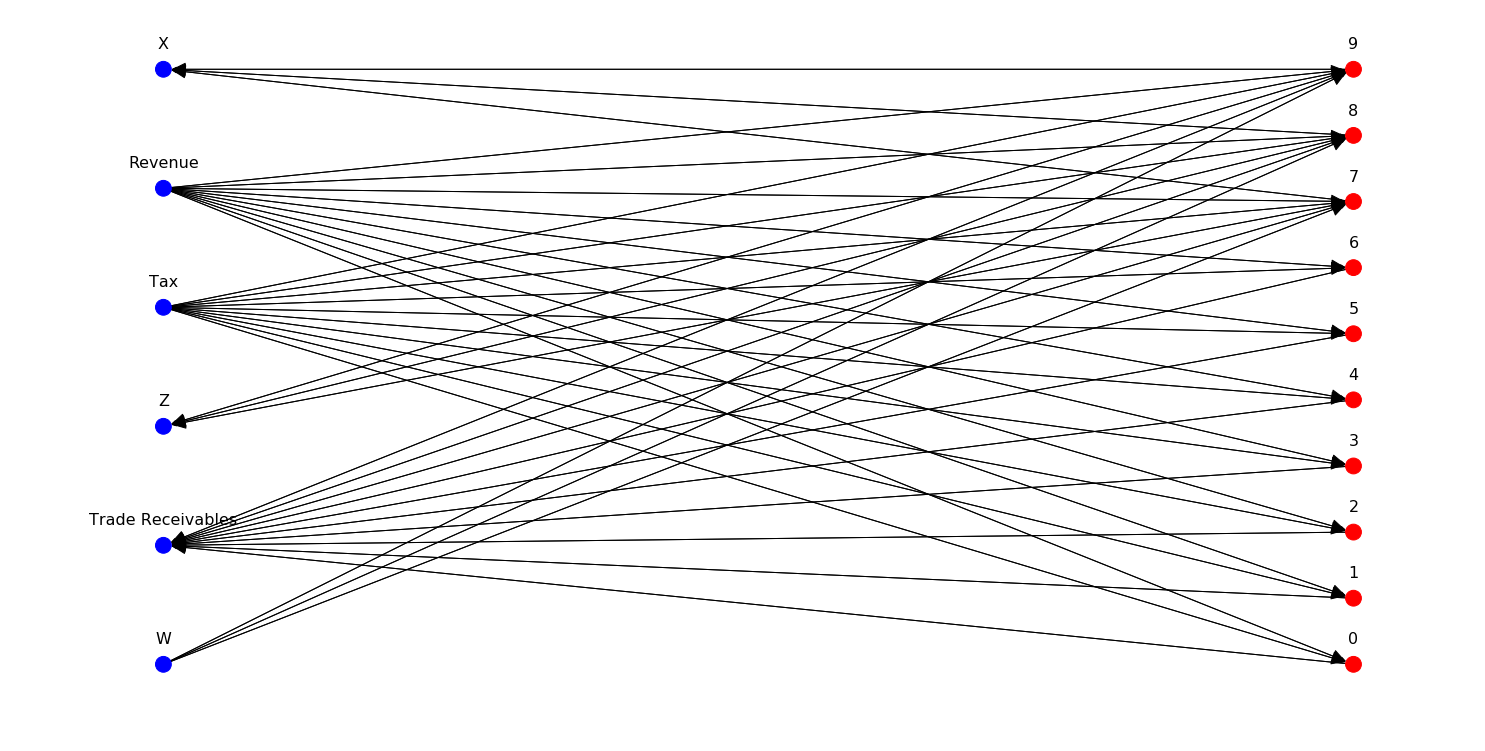

In [337]:
plot_network(exp2, title="Exp2", edges_label=False)

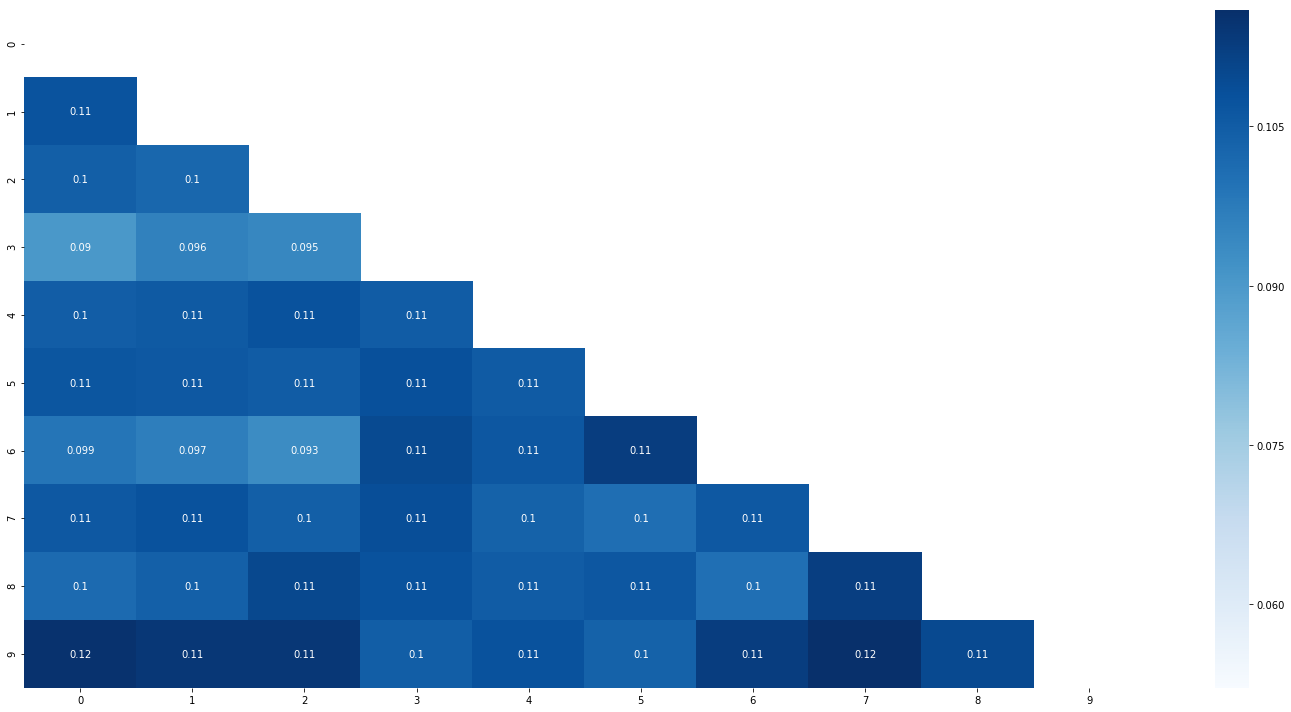

In [457]:
pairs2 = [make_pairs(randomWalk(exp2, node, 10, direction="IN", repeat=False, pressure=20)) for _ in range(100) for node in range(10)]
pairs2 = [item for sublist in pairs2 for item in sublist]
plot_heatmap(pairs2, "HeatExp2", 10, "col")

### Experiment 3. Transition

In [417]:
from scipy.special import softmax
mask = {"IN": "OUT", "OUT": "IN"}
indexes = ["IN", "OUT"]
def step_v2(G, vertex, direction="IN", p=0.2, allow_back=False, pressure=20, debug=False):
    ws = list()
    tmp_vertex = None
    tmp_weight = None
    #         Making one step from BP node to Financial account node with transition probability ~ weights of edges.
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        print("Wrong direction argument! IN or OUT are allowed!")
    if len(ins) > 0:
        ws = [edge[-1]["weight"] for edge in ins]
        p_ws = ws / np.sum(ws)
        ins = [edge[indexes.index(direction)] for edge in ins]
        tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
        tmp_vertex = ins[tmp_idx]
        tmp_weight = ws[tmp_idx]
        if debug:
            print(tmp_vertex)
    else:
        return -1
    #             Making the 2nd step from FA to BP node (actual sampling)
#     Chose the direction of next sub-step:
    if random.random()>p:
        new_direction = mask[direction]
    else:
        if debug:
            print("Continue deeper")
        new_direction = direction
    if debug:
        print(new_direction)
#         Actual step
    if new_direction=="IN":
        outs = G.in_edges(tmp_vertex, data=True)
    elif new_direction=="OUT":
        outs = G.out_edges(tmp_vertex, data=True)
    if len(outs) > 0:
        ws = [edge[-1]["weight"] for edge in outs]
        outs = [edge[indexes.index(new_direction)] for edge in outs]
        if not allow_back and direction!=new_direction:
            rm_idx = outs.index(vertex)
            ws.pop(rm_idx)
            outs.pop(rm_idx)
        if len(outs)==0:
            return -3
        ws = np.array(ws)
        ws = softmax((1.0 - abs(ws - tmp_weight))*pressure)
        if debug:
            print(list(zip(outs, ws)))
        return np.random.choice(outs, p=ws)
    else:
        return -2

In [387]:
def randomWalk_v2(G, vertex=None, lenght=3, direction="IN", p=0.2, repeat=True, pressure=20, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = step_v2(G, cur_v, direction, p=p, debug=debug, pressure=pressure)
            attempts-=1
        except nx.NetworkXError:
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [381]:
# Construct test case with Sale BPs with sequential chain of BPs: A->B->C etc.
def generate_transition_df(N=2):
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for it in range(N):
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "A", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "B", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "C", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
#             2nd BP
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "C", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "D", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "E", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
            #             2nd BP
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "E", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "F", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "D", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
    return data

In [409]:
generated_data = normalize(generate_transition_df(3))
exp3 = construct_graph(generated_data)
generated_data.tail(10)

,ID,Name,Journal,Date,Debit,Credit,from
17,5,D,Sales ledger,01/01/2017,1.0,0.000000,False
18,6,A,Sales ledger,01/01/2017,0.0,0.833333,True
19,6,B,Sales ledger,01/01/2017,0.0,0.166667,True
20,6,C,Sales ledger,01/01/2017,1.0,0.000000,False
21,7,C,Sales ledger,01/01/2017,0.0,0.833333,True
22,7,D,Sales ledger,01/01/2017,0.0,0.166667,True
23,7,E,Sales ledger,01/01/2017,1.0,0.000000,False
24,8,E,Sales ledger,01/01/2017,0.0,0.833333,True
25,8,F,Sales ledger,01/01/2017,0.0,0.166667,True
26,8,D,Sales ledger,01/01/2017,1.0,0.000000,False


/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


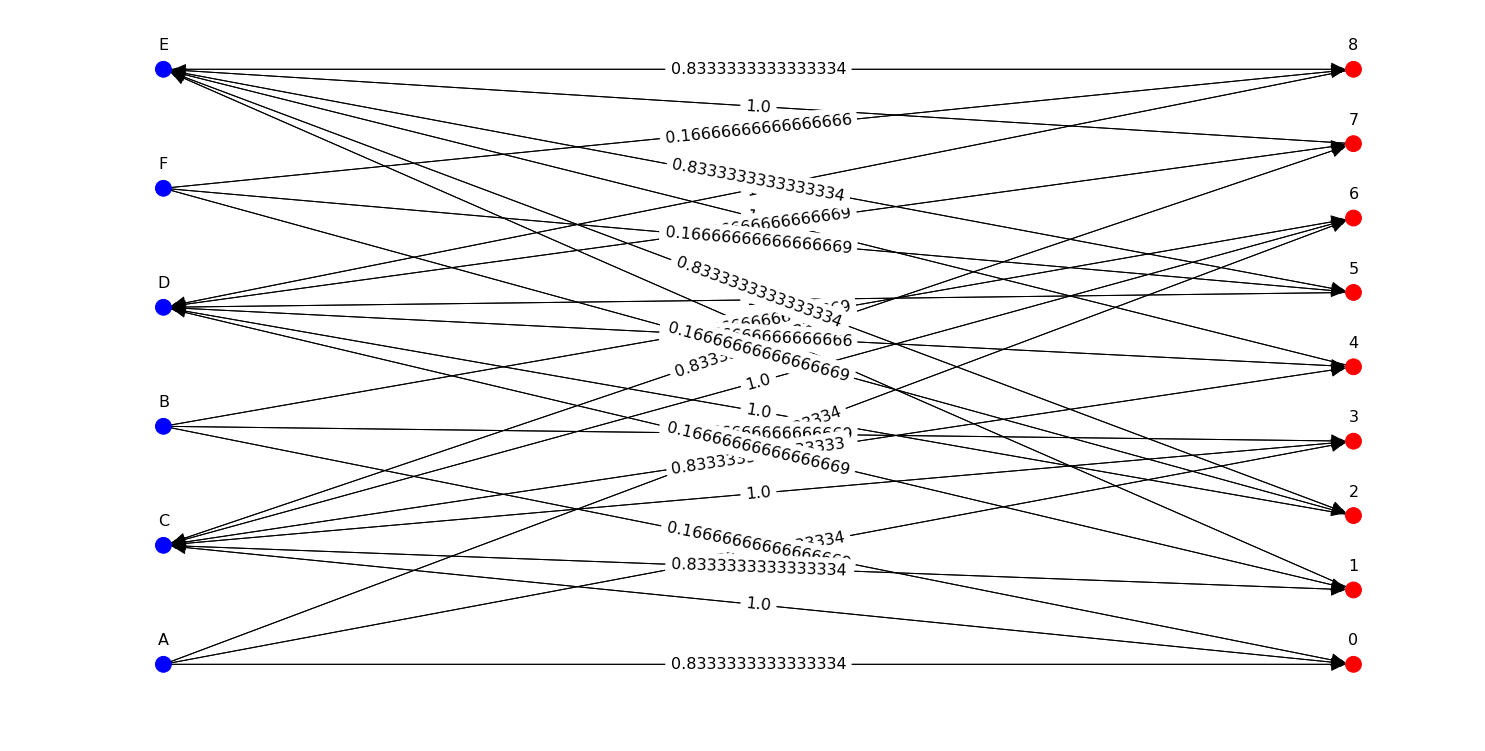

In [410]:
plot_network(exp3, title="Exp3")

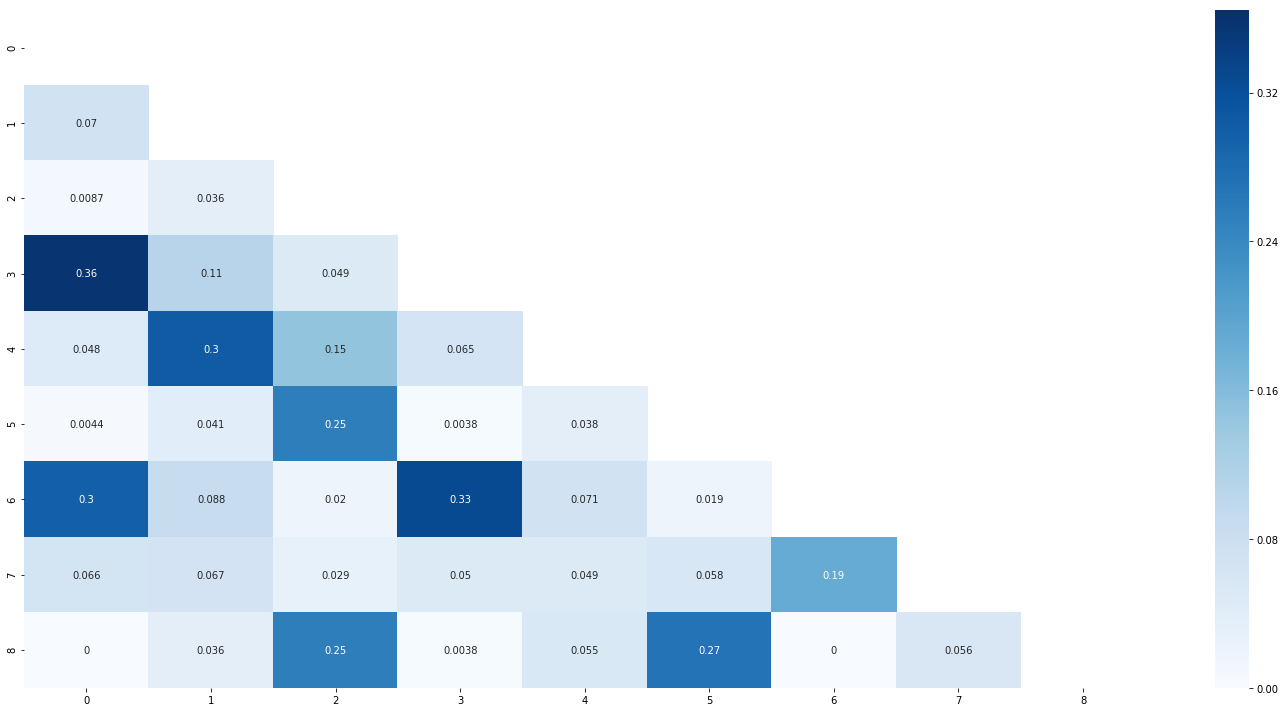

In [460]:
pairs3 = [make_pairs(randomWalk_v2(exp3, node, 10, direction="IN", p=0.3, repeat=False, pressure=10)) for _ in range(10) for node in range(9)]
pairs3 = [item for sublist in pairs3 for item in sublist]
plot_heatmap(pairs3, "HeatExp3", 9, "col")
# Counter(pairs3)